In [1]:
import sys

!{sys.executable} -m pip install dm-control
!{sys.executable} -m pip install pillow
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install imageio[ffmpeg]

In [2]:
!arch -arm64 brew install ffmpeg

==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
cargo-dist                 libheinz                   showcert
cargo-flamegraph           libsvgtiny                 streamrip
cargo-msrv                 lol-html                   swc
cdncheck                   ltex-ls-plus               tach
chaos-client               monocle                    termbg
codeberg-cli               netatalk                   tiny
codesnap                   openapi-tui                vgt
gh-ost                     periphery                  vue-language-server
ghc@9.10                   pinact                     wcstools
go-parquet-tools           proxyfor                   xc
harper                     ratify                     xmq
kube-bench                 ruby@3.3    

In [29]:
from dm_control import mujoco
from dm_control.suite import common
from dm_control.utils import containers
from lxml import etree
import numpy as np
from PIL import Image
import random
from dm_control import viewer
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, Video
import os
import imageio
from dm_control import mjcf

os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/local/bin/ffmpeg" 

## Tests

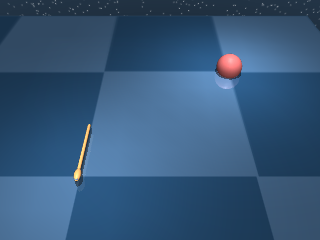

In [15]:
# Visualize swimmer 4 body
physics = mujoco.Physics.from_xml_path('../zfa_rl_agent/mujoco_bodies/swimmer4_limited_joints.xml')
PIL.Image.fromarray(physics.render())

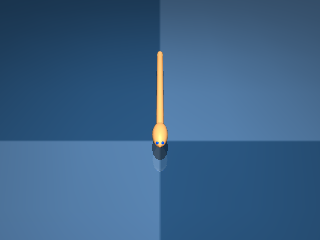

In [16]:
# Removed target from swimmer 4 body
physics = mujoco.Physics.from_xml_path('../zfa_rl_agent/mujoco_bodies/swimmer_no_target.xml')
PIL.Image.fromarray(physics.render())

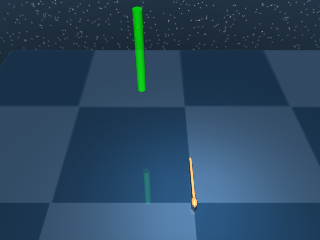

In [17]:
# Random obstacle
physics = mujoco.Physics.from_xml_path('../zfa_rl_agent/mujoco_bodies/swimmer_random_obstacle.xml')
PIL.Image.fromarray(physics.render())

## XML Functions

In [18]:
def _make_body(body_index):
  """Generates an xml string defining a single physical body."""
  body_name = 'segment_{}'.format(body_index)
  visual_name = 'visual_{}'.format(body_index)
  inertial_name = 'inertial_{}'.format(body_index)
  body = etree.Element('body', name=body_name)
  body.set('pos', '0 .1 0')
  etree.SubElement(body, 'geom', {'class': 'visual', 'name': visual_name})
  etree.SubElement(body, 'geom', {'class': 'inertial', 'name': inertial_name})
  return body

def _make_model(n_bodies, positions, num_obstacles=0):
  """Generates an xml string defining a swimmer with `n_bodies` bodies."""
  if n_bodies < 3:
    raise ValueError('At least 3 bodies required. Received {}'.format(n_bodies))
  mjcf = etree.fromstring(common.read_model('swimmer.xml'))
  
  head_body = mjcf.find('./worldbody/body')
  actuator = etree.SubElement(mjcf, 'actuator')
  sensor = etree.SubElement(mjcf, 'sensor')

  # Change ground background 
  asset = etree.SubElement(mjcf, 'asset')
  etree.SubElement(asset, 'texture', {
    'name': 'grass_tex',
    'type': '2d',
    'file': '../mujoco_bodies/common/OutdoorGrassFloorD.png'
  })
  etree.SubElement(asset, 'material', {
    'name': 'grass_mat',
    'texture': 'grass_tex',
    'specular': '0.3',
    'shininess': '0.1'
  })

  ground_geom = mjcf.find('.//geom[@name="ground"]')
  if ground_geom is not None:
    ground_geom.set('material', 'grass_mat')


  # Remove target from the model
  target = mjcf.find('.//geom[@name="target"]')
  target_light = mjcf.find('.//light[@name="target_light"]')
  target_sensor = mjcf.find('.//sensor/framepos[@name="target_pos"][@objname="target"]')
  if target is not None:
      target.getparent().remove(target) 
  if target_light is not None:
      target_light.getparent().remove(target_light) 
  if target_sensor is not None:
      target_sensor.getparent().remove(target_sensor)

  parent = head_body
  for body_index in range(n_bodies - 1):
    site_name = 'site_{}'.format(body_index)
    child = _make_body(body_index=body_index)
    child.append(etree.Element('site', name=site_name))
    joint_name = 'joint_{}'.format(body_index)
    joint_limit = 360.0/n_bodies
    joint_range = '{} {}'.format(-joint_limit, joint_limit)
    child.append(etree.Element('joint', {'name': joint_name,
                                         'range': joint_range}))
    motor_name = 'motor_{}'.format(body_index)
    actuator.append(etree.Element('motor', name=motor_name, joint=joint_name))
    velocimeter_name = 'velocimeter_{}'.format(body_index)
    sensor.append(etree.Element('velocimeter', name=velocimeter_name,
                                site=site_name))
    gyro_name = 'gyro_{}'.format(body_index)
    sensor.append(etree.Element('gyro', name=gyro_name, site=site_name))
    parent.append(child)
    parent = child

  # Obstacles
  height = 0.1
  for obstacle in range(num_obstacles):
    rand_pos = str(positions[obstacle][0]) + ' ' + str(positions[obstacle][1]) + ' ' +  str(height/2)
    obstacle = etree.Element('geom', {
    'name': f'obstacle_{obstacle}',
    'type': 'cylinder',
    'mass': '1',
    'size': '0.05 0.1', # Radius and height of the cylinder
    'rgba': '0 1 0 0.5',           
    'pos': rand_pos             
    })
    mjcf.find('./worldbody').append(obstacle)
  # Move tracking cameras further away from the swimmer according to its length.
  cameras = mjcf.findall('./worldbody/body/camera')
  scale = n_bodies / 6.0
  for cam in cameras:
    if cam.get('mode') == 'trackcom':
      old_pos = cam.get('pos').split(' ')
      new_pos = ' '.join([str(float(dim) * scale) for dim in old_pos])
      cam.set('pos', new_pos)

  return etree.tostring(mjcf, pretty_print=True)



## Density environment

In [19]:
def check_overlap(new_pos, obstacle_positions, min_dist):
    for pos in obstacle_positions:
        # Calculate the Euclidean distance between the new position and the existing ones
        dist = np.linalg.norm(np.array(new_pos) - np.array(pos))
        if dist < min_dist:  # If the distance is less than the minimum distance, they overlap
            return True
    return False

In [20]:
# Create an XML tree
file_path = '../zfa_rl_agent/mujoco_bodies/swimmer_random_obstacles.xml' # Replace with your actual file path

# Parse the XML file
tree = etree.parse(file_path)
root = tree.getroot()

# Function to find the element by name attribute
def get_element_position(root, body_name):
    body_element = root.find(f".//body[@name='{body_name}']")
    if body_element is not None:
        return body_element.get("pos")
    return None

# Get the number of segments
num_segments = 0
while True:
    segment_position = get_element_position(root, f"segment_{num_segments}")
    if segment_position is not None:
        last_segment_position = segment_position
        num_segments += 1
    else:
        break

# size_body = head_size + 0.1 * num_segments
size_body = 0.04 + 0.1 * num_segments
print(size_body)

0.34


In [21]:

# Ground
ground_size = physics.named.model.geom_size['ground'] * 2 
ground_area = ground_size[0] * ground_size[1] 

# Obstacle
obstacle_size = 0.05 * 2  # radius * 2
obstacle_area = obstacle_size ** 2 

# Size of fish
#physics.named.model.geom_size['segment_0'] 

# Density
density = 0.01  # [0, 1]

# Possible coordinates for obstacles
x_min_neg = -(ground_size[0]/2) 
x_max_neg = -(size_body + obstacle_size/2)
x_min_pos = size_body  + obstacle_size/2
x_max_pos = (ground_size[0])/2

y_min_neg = -(ground_size[1]/2)
y_max_neg = -(size_body + obstacle_size/2)
y_min_pos = size_body + obstacle_size/2
y_max_pos = (ground_size[1]/2)

# Calcule the area to be covered by obstacles
inside_area = (x_max_neg - x_min_pos) * (y_max_neg - y_min_pos) # Area of the inner square that has no obstacles
desired_covered_area = (ground_area - inside_area) * density  # Total area to be covered by obstacles

# Calculate the number of obstacles
n_obstacles = int(desired_covered_area / obstacle_area)
min_distance = obstacle_size / 2 


In [22]:
# Add obstacles randomly until the required number is placed
obstacle_positions = []
obstacle_count = 0
while obstacle_count < n_obstacles:
    x_or_y = random.choice(['x', 'y'])

    if x_or_y == 'x':
        x_pos = random.uniform(x_min_neg, x_max_pos)
        if x_pos < x_min_pos and x_pos > x_max_neg:
            # If the x position is in the inner square, the y position must be outside of it
            y_range = random.choice([(y_min_neg, y_max_neg), (y_min_pos, y_max_pos)])
            y_pos = random.uniform(y_range[0], y_range[1])
        else:
            # If the x position is outside of the inner square, the y position can be anywhere
            y_pos = random.uniform(y_min_neg, y_max_pos)
    else:
        y_pos = random.uniform(y_min_neg, y_max_pos)
        if y_pos < y_min_pos and y_pos > y_max_neg:
            # If the y position is in the inner square, the x position must be outside of it
            x_range = random.choice([(x_min_neg, x_max_neg), (x_min_pos, x_max_pos)])
            x_pos = random.uniform(x_range[0], x_range[1])
        else:
            # If the y position is outside of the inner square, the x position can be anywhere
            x_pos = random.uniform(x_min_neg, x_max_pos)
    
    # Check if the new position overlaps with any existing obstacle
    if not check_overlap([x_pos, y_pos], obstacle_positions, min_distance):
        obstacle_positions.append([x_pos, y_pos])
        obstacle_count += 1

Swimmer model saved to ../zfa_rl_agent/mujoco_bodies/swimmer_random_obstacles.xml


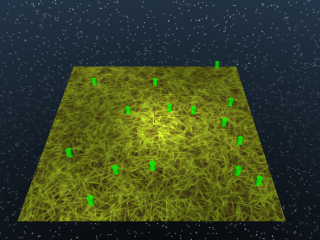

In [23]:
# Add the obstacle to the model
xml_string = _make_model(4, obstacle_positions, obstacle_count)
# Save the XML string to a file.
output_path = "../zfa_rl_agent/mujoco_bodies/swimmer_random_obstacles.xml"
with open(output_path, "wb") as f:
    f.write(xml_string)

print(f"Swimmer model saved to {output_path}")

physics = mujoco.Physics.from_xml_path('..//zfa_rl_agent/mujoco_bodies/swimmer_random_obstacles.xml')
PIL.Image.fromarray(physics.render())

## Pinball Environment

In [24]:
# Ground
ground_size = physics.named.model.geom_size['ground'] * 2 
ground_area = ground_size[0] * ground_size[1] 

# Obstacle
obstacle_size = 0.05 * 2  # radius * 2
obstacle_area = obstacle_size ** 2 

Spacing: 2.0


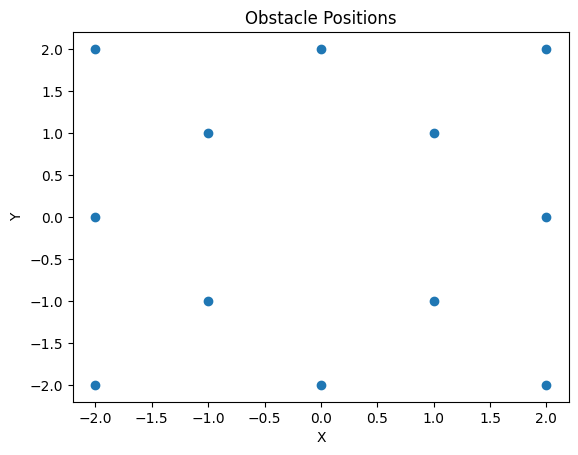

In [25]:
n = 3  # Number of obstacles per main line
min_pos, max_pos = -ground_size[0]/2, ground_size[1]/2 # Range for x and y

# Define the inner square boundaries
inner_min_x, inner_max_x = -0.25, 0.25 # 
inner_min_y, inner_max_y = -0.25, 0.25

# Calculate the spacing between obstacles
spacing = (max_pos - min_pos) / (n - 1)
spacing_half = spacing / 2  # Pre-calculate half spacing to avoid redundancy

print(f"Spacing: {spacing}")

# Generate the obstacle positions for the main line (n) and staggered line (n-1)
x_coords_n = np.linspace(min_pos, max_pos, n)
y_coords_n = np.linspace(min_pos, max_pos, n)
x_coords_n_minus_1 = np.linspace(min_pos + spacing_half, max_pos - spacing_half, n - 1)
y_coords_n_minus_1 = np.linspace(min_pos + spacing_half, max_pos - spacing_half, n - 1)

positions_n = [(x, y) for x in x_coords_n for y in y_coords_n]
positions_n_minus_1 = [(x, y) for x in x_coords_n_minus_1 for y in y_coords_n_minus_1]

# Combine both sets of positions
positions = positions_n + positions_n_minus_1

# Filter out points that fall within the inner square
filtered_positions = [
    (x, y) for x, y in positions
    if not (inner_min_x <= x <= inner_max_x and inner_min_y <= y <= inner_max_y)
]

import matplotlib.pyplot as plt
# Create a scatter plot of the obstacle positions
plt.scatter(*zip(*filtered_positions))
plt.title("Obstacle Positions")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()



Swimmer model saved to ../zfa_rl_agent/mujoco_bodies/swimmer_pinball_obstacles.xml


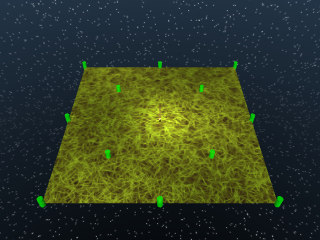

In [26]:
# Add the obstacle to the model
xml_string = _make_model(4, filtered_positions, len(filtered_positions))
# Save the XML string to a file.
output_path = "../zfa_rl_agent/mujoco_bodies/swimmer_pinball_obstacles.xml"
with open(output_path, "wb") as f:
    f.write(xml_string)

print(f"Swimmer model saved to {output_path}")

physics = mujoco.Physics.from_xml_path('../zfa_rl_agent/mujoco_bodies/swimmer_pinball_obstacles.xml')
PIL.Image.fromarray(physics.render())

## Drifting Grating

In [163]:
def generate_striped_texture(image_size, line_width, line_spacing):
    """
    Generate a black-and-red striped texture with adjustable parameters.
    By default, stripes are horizontal (since we iterate over y),
    but you can adapt for vertical by iterating over x.
    """
    width, height = image_size
    
    # Create a black image (all channels initialized to 0)
    texture = np.zeros((height, width, 3), dtype=np.uint8)

    # Draw horizontal red stripes
    for y in range(0, height, int(line_width + line_spacing)):
        y_end = min(y + line_width, height)  # avoid out-of-bounds
        texture[y:y_end, :, 0] = 0  # Red channel
        texture[y:y_end, :, 1] = 0    # Green channel
        texture[y:y_end, :, 2] = 255    # Blue channel

    return texture

In [164]:
# Create an XML tree
file_path = '../zfa_rl_agent/mujoco_bodies/swimmer_drifting_grating.xml'

# Parse the XML file
tree = etree.parse(file_path)
root = tree.getroot()

# Function to find the element by name attribute
def get_element_position(root, body_name):
    body_element = root.find(f".//body[@name='{body_name}']")
    if body_element is not None:
        return body_element.get("pos")
    return None

# Get the number of segments
num_segments = 0
while True:
    segment_position = get_element_position(root, f"segment_{num_segments}")
    if segment_position is not None:
        last_segment_position = segment_position
        num_segments += 1
    else:
        break

# size_body = head_size + 0.1 * num_segments
size_body = 0.08 + 0.1 * num_segments
print(f"Size of swimmer body in MuJoCo: {size_body}")

Size of swimmer body in MuJoCo: 0.38000000000000006


In [165]:
zf_length = 0.0045  # Zebrafish length in meters (4.5 mm)
length_ratio = zf_length / size_body
print(f"Ratio (real fish / MuJoCo fish): {length_ratio:.5f}")

Ratio (real fish / MuJoCo fish): 0.01184


In [177]:
ground_object = root.find(f".//body[@name='moving_floor_body']/geom")
ground_size = ground_object.get('size').split()

scaled_ground_size = (float(ground_size[0]) * 2) * length_ratio 
print(f"Scaled ground size: {scaled_ground_size:.3f} m")

Scaled ground size: 0.237 m


In [178]:
num_pixels = int(scaled_ground_size * 10000)  # e.g. 1 m => 10,000 px
num_pixels = max(num_pixels, 1)  # prevent zero or negative
print(f"Texture resolution: {num_pixels} x {num_pixels}")

pixel_size = scaled_ground_size / num_pixels
print(f"Pixel size: {pixel_size:.6f} m/pixel")

Texture resolution: 2368 x 2368
Pixel size: 0.000100 m/pixel


In [179]:
line_width_mm = 2.5
line_width_m = line_width_mm / 1000.0  # => 0.0025 m
line_width_px = int(line_width_m / pixel_size)
print(f"Stripe width: {line_width_mm} mm => {line_width_px} px")

line_spacing_mm = 2.5
line_spacing_m = line_spacing_mm / 1000.0
line_spacing_px = int(line_spacing_m / pixel_size)

Stripe width: 2.5 mm => 24 px


In [180]:
image_size = (num_pixels, num_pixels)
striped_texture = generate_striped_texture(image_size, line_width_px, line_spacing_px)
image = Image.fromarray(striped_texture)
image_filename = "../zfa_rl_agent/mujoco_bodies/striped_texture.png"
image.save(image_filename)
image.show()
print(f"Striped texture saved to {image_filename}")

Striped texture saved to ../zfa_rl_agent/mujoco_bodies/striped_texture.png


In [181]:
xml_file = '../zfa_rl_agent/mujoco_bodies/swimmer_drifting_grating.xml'
with open(xml_file, 'r') as f:
    xml_contents = f.read()
mjcf_model = mjcf.from_xml_string(xml_contents)

moving_body = mjcf_model.find('body', 'moving_floor_body')
floor_joint = mjcf_model.find('joint', 'floor_joint_y')

_offset_y = 0.0
num_frames = 100
frame_rate = 30

# Speed in mm/s, convert to m/s, then scale to MuJoCo speed
zf_speed_mm_s = 2.86
zf_speed_m_s = zf_speed_mm_s / 1000
simulation_speed = zf_speed_m_s / length_ratio
_speed = simulation_speed / frame_rate

_physics = mjcf.Physics.from_mjcf_model(mjcf_model)
video_filename = "simulation_video.mp4"
frames = []

for _ in range(num_frames):    
    _offset_y -= _speed
    joint_index = _physics.model.jnt_qposadr[0]
    _physics.data.qpos[joint_index] = _offset_y

    _physics.step()

    # Render a frame
    pixels = _physics.render(height=240, width=320, camera_id=2)
    frames.append(pixels)

# Save frames to a video file
imageio.mimsave(video_filename, frames, fps=frame_rate)
print(f"Video saved to {video_filename}")

# Display the video directly in the notebook
display(Video(video_filename, embed=True))

Video saved to simulation_video.mp4


[h264_videotoolbox @ 0x136e05200] Color range not set for yuv420p. Using MPEG range.
